In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import deepxde as dde
from deepxde.backend import tf
import seaborn as sns

%matplotlib inline

sns.set_context("talk")
dde.config.set_default_float("float64")
dde.config.set_random_seed(0)

x_max = 1e-3
y_max = 0.23e-3
t_max = 0.001

geo = dde.geometry.Hypercube((0.0, 0.0), (x_max, y_max))
time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_n = 301.3
T_h = 1500

def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dt = dde.grad.jacobian(T, X, j = 2)
    
    k = tf.cast(11.82+1.06e-2*T, 'float64')
    c = tf.cast(330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3, 'float64')
    rho = tf.cast(7800.0*T**0, 'float64')
    
    k_eff = k
    rho_eff = rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1)
    
    f_T = (rho_eff*c)*dT_dt - diff_T
        
    return f_T

ic = dde.icbc.IC(domain, lambda on_initial: T_n, lambda x, on_initial: on_initial and not np.isclose(x[1], y_max, atol=y_max/20))
top = dde.icbc.DirichletBC(domain, lambda X : T_h, lambda x, on_boundary: on_boundary and np.isclose(x[1], y_max, atol=y_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : T_n, lambda x, on_boundary: on_boundary and not np.isclose(x[1], y_max, atol=y_max/20))

geo_bound = dde.geometry.geometry_1d.Interval(0, x_max)#.Hypercube((0), (x_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, t_bound = domain_bound.random_points(1000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_max*np.ones(len(x_bound)), t_bound)).T
input_domain = domain.random_points(1000, random='Hammersley')

input_data = np.vstack((input_bound, input_domain))

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5)*2, 
            (X[:, 1:2]/y_max - 0.5)*2,
            (X[:, 2:3]/t_max - 0.5)*2], axis=1)

def modify_output(X, Y):
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
    Temperature = Y
        #T_new = 20.0 + T_0 + Temperature*4000e22*x*y*(x-x_max)*(y-y_max)*t*z
    T_new = T_n + Temperature*5e16*x*y*(x-x_max)*t
    return tf.concat(T_new, axis = 1)

end_data = np.genfromtxt('heat_conduction/dat.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
X = np.vstack((x, y, np.ones(len(x))*t_max)).T

Using backend: tensorflow.compat.v1

2023-02-27 11:31:29.741048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-02-27 11:31:32.691274: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 11:31:32.692392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-27 11:31:32.714774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 11:31:32.714810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 11:31:32.716761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 11:31:32.716812: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2





Set the default float type to float64


Compiling model...
Building feed-forward neural network...
'build' took 0.101830 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-02-27 11:31:33.800446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 11:

'compile' took 5.959599 s

Initializing variables...


2023-02-27 11:31:39.767709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-02-27 11:31:39.928377: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Training model...



2023-02-27 11:31:40.555776: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15273800a910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-27 11:31:40.555833: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-02-27 11:31:40.905683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 11:31:42.582743: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [8.27e+24, 8.58e+05]    [6.04e+23, 8.58e+05]    []  

Best model at step 0:
  train loss: 8.27e+24
  test loss: 6.04e+23
  test metric: []

'train' took 6.073308 s

Compiling model...
'compile' took 4.820850 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [3.24e+02, 2.34e+01]    [1.65e+01, 2.34e+01]    []  
10        [1.89e+00, 6.51e+00]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 8.364762
  Number of iterations: 7
  Number of functions evaluations: 11
11        [1.87e+00, 6.49e+00]    [3.20e-01, 6.49e+00]    []  

Best model at step 11:
  train loss: 8.36e+00
  test loss: 6.81e+00
  test metric: []

'train' took 13.675306 s



2023-02-27 11:32:04.839974: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1642] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss              Test loss               Test metric
11        [1.87e+00, 6.49e+00]    [3.20e-01, 6.49e+00]    []  
20        [1.79e+00, 5.85e+00]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 7.530207
  Number of iterations: 7
  Number of functions evaluations: 11
22        [1.88e+00, 5.65e+00]    [5.84e-01, 5.65e+00]    []  

Best model at step 22:
  train loss: 7.53e+00
  test loss: 6.23e+00
  test metric: []

'train' took 1.234812 s

Training model...

Step      Train loss              Test loss               Test metric
22        [1.88e+00, 5.65e+00]    [5.84e-01, 5.65e+00]    []  
30        [1.65e+00, 5.80e+00]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 7.272075
  Number of iterations: 7
  Number o

2023-02-27 11:34:32.779635: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 11:34:32.780453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 11:34:32.780534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 11:34:32.780584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 11:34:32.780619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 11:34:32.780655: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 6.204563 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [7.79e+23, 1.65e+06]    [4.92e+23, 1.65e+06]    []  

Best model at step 0:
  train loss: 7.79e+23
  test loss: 4.92e+23
  test metric: []

'train' took 7.938790 s

Compiling model...
'compile' took 5.346810 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.29e+01, 6.79e+00]    [8.32e+00, 6.79e+00]    []  
10        [7.78e-01, 6.96e+00]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 7.731300
  Number of iterations: 8
  Number of functions evaluations: 11
11        [7.94e-01, 6.94e+00]    [7.73e-02, 6.94e+00]    []  

Best model at step 11:
  train loss: 7.73e+00
  test loss: 7.02e+00
  test metric: []

'train' took 17.057434 s

Training

2023-02-27 11:40:47.411159: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 11:40:47.412049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 11:40:47.412133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 11:40:47.412183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 11:40:47.412217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 11:40:47.412258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 5.637816 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.90e+24, 2.05e+06]    [2.22e+24, 2.05e+06]    []  

Best model at step 0:
  train loss: 1.90e+24
  test loss: 2.22e+24
  test metric: []

'train' took 8.615545 s

Compiling model...
'compile' took 5.515761 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.82e+00, 1.02e+01]    [2.61e+00, 1.02e+01]    []  
10        [9.21e-01, 4.72e+00]                                
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  Objective function value: 5.547235
  Number of iterations: 9
  Number of functions evaluations: 11
11        [9.32e-01, 4.62e+00]    [3.26e-01, 4.62e+00]    []  

Best model at step 11:
  train loss: 5.55e+00
  test loss: 4.94e+00
  test metric: []

'train' took 18.115857 s

Training

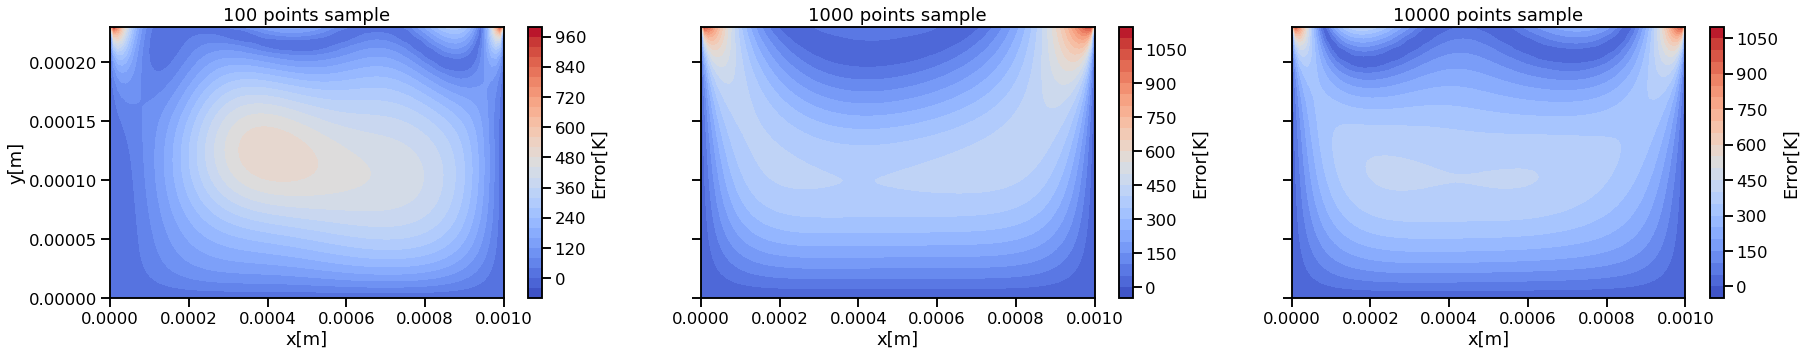

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 5), sharex=True, sharey=True)

ax1.set_ylabel('y[m]')
ax1.set_xlabel('x[m]')
ax2.set_xlabel('x[m]')
ax3.set_xlabel('x[m]')

losses = []

for number, ax, n in zip([1e2, 1e3, 1e4], [ax1, ax2, ax3], [1, 2, 3]):
   
    dde.config.set_random_seed(1234)
    tf.random.set_random_seed(1234)
    np.random.seed(1234)
    
    x_bound, t_bound = domain_bound.random_points(int(number), random='Hammersley').T
    input_bound = np.vstack((x_bound, y_max*np.ones(len(x_bound)), t_bound)).T
    input_domain = domain.random_points(int(number), random='Hammersley')
    input_data = np.vstack((input_bound, input_domain))
    
    net = dde.nn.FNN([3] + [20] * 4 + [1], "sin", "Glorot normal")
    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(modify_output)

    data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 0,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1000,
                       anchors=input_data)
    
    model = dde.Model(data, net)
    model.compile("adam", lr=1e-3)

    losshistory, train_state = model.train(iterations=0, display_every=1000)
    weights = 1/np.array(losshistory.loss_train[0])
    
    dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=10, maxfun = 10, maxls=50)
    model.compile('L-BFGS', loss_weights=weights*np.array([1, 10]))
    
    for i in range(100):
        losshistory, train_state = model.train(display_every=10)
    Y = model.predict(X)

    predict = griddata((np.ravel(x), np.ravel(y)), np.abs(Y[:,0]-T), (xi[None,:], yi[:,None]), method='cubic')

    im = ax.contourf(xi, yi, predict, 25, cmap=plt.cm.coolwarm)
        
    plt.colorbar(im, label='Error[K]', ax=ax)  
    ax.set_title('{} points sample'.format(int(number)))
    
    losses.append(losshistory)

#plt.savefig('number.pdf')
plt.show()

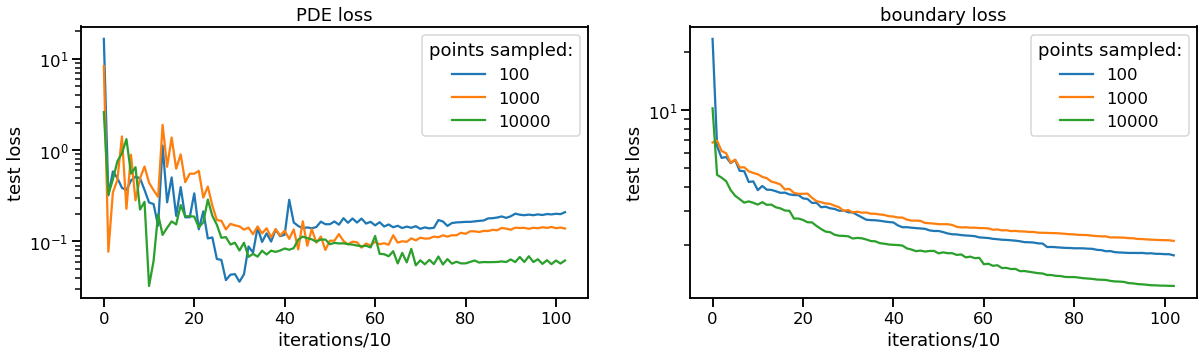

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20, 5))

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlabel(r'iterations/$10$')
ax2.set_xlabel(r'iterations/$10$')
ax1.set_ylabel('test loss')
ax2.set_ylabel('test loss')

for loss, number in zip(losses, [100, 1000, 10000]):
    
    ax1.plot(np.array(loss.loss_test).T[0, 1:-1:3], label = number)
    ax2.plot(np.array(loss.loss_test).T[1, 1:-1:3], label = number)
    
#ax1.legend(ncol=6, bbox_to_anchor= (1.83, -0.25))
ax1.legend(title = 'points sampled:')
ax2.legend(title = 'points sampled:')

ax1.set_title('PDE loss')
ax2.set_title('boundary loss')
plt.savefig('parameter_pics/number_loss.pdf', bbox_inches='tight')
plt.show()